<a href="https://colab.research.google.com/github/HPractor/SIH-Final-Project/blob/main/Ensemble_with_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [ ]:
a=pd.read_csv("Aloo preprocessed_dataset.csv")

In [ ]:
# Generate synthetic time series data
np.random.seed(42)
n_samples = 100
n_features = 5

# Simulate time series data with a trend and noise
time = np.arange(n_samples)
data = np.array([np.sin(0.1 * time) + np.random.normal(scale=0.5, size=n_samples) for _ in range(n_features)]).T

# Convert to DataFrame
a = pd.DataFrame(data, columns=[f'Feature_{i}' for i in range(n_features)])


In [ ]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(a)


In [ ]:
# Initialize PCA
pca = PCA()

# Fit and transform the data
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Print explained variance by each component
for i, variance in enumerate(explained_variance):
    print(f'Principal Component {i+1}: Explained variance = {variance}')

# Print total explained variance
print(f'Total explained variance: {sum(explained_variance)}')


Principal Component 1: Explained variance = 0.7470342654502147
Principal Component 2: Explained variance = 0.09484086968878878
Principal Component 3: Explained variance = 0.058976403925055675
Principal Component 4: Explained variance = 0.05730814362617655
Principal Component 5: Explained variance = 0.0418403173097644
Total explained variance: 1.0


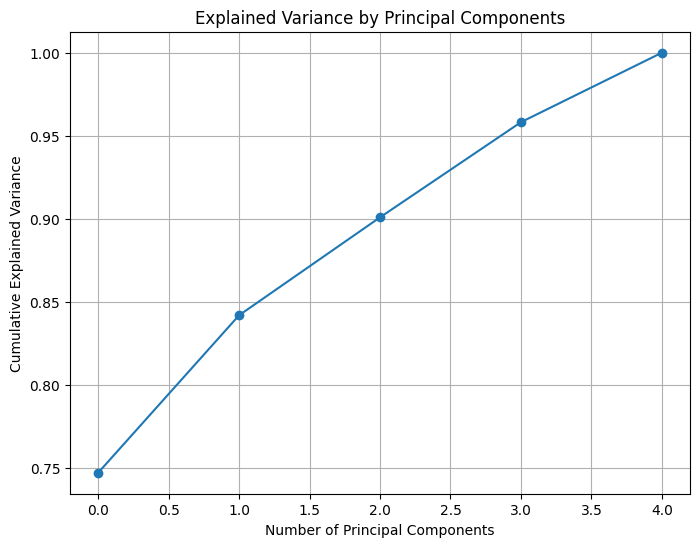

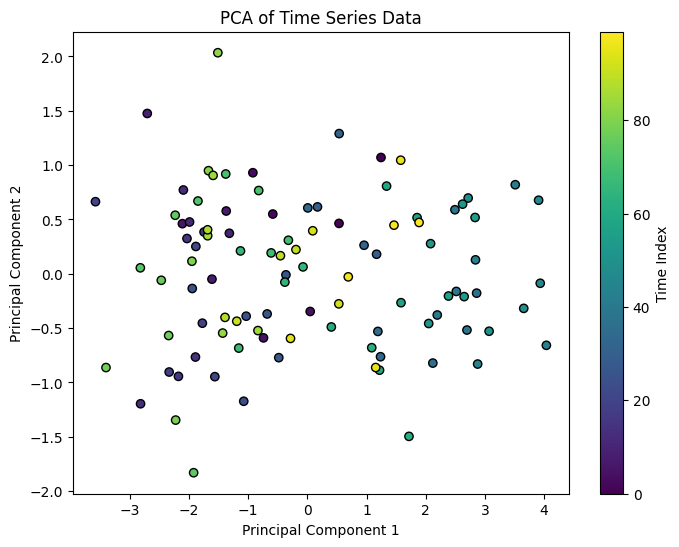

In [ ]:
# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()

# Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=np.arange(n_samples), cmap='viridis', edgecolor='k')
plt.colorbar(label='Time Index')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Time Series Data')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

# Create a sample DataFrame 'a' for demonstration purposes with more data points
a = pd.DataFrame({'Modal Price (Rs./Quintal)': np.random.rand(100)})

# Create features and target variables
X = a[['Modal Price (Rs./Quintal)']]
y = a['Modal Price (Rs./Quintal)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train ARIMA model
def train_arima(train):
    model_arima = ARIMA(train, order=(2, 1, 2))  # Adjust order based on your data
    model_fit_arima = model_arima.fit()
    return model_fit_arima

def predict_arima(model, steps):
    forecast = model.forecast(steps=steps)
    return forecast

# Train SARIMA model
def train_sarima(train):
    model_sarima = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))  # Adjust order based on your data
    model_fit_sarima = model_sarima.fit()
    return model_fit_sarima

def predict_sarima(model, steps):
    forecast = model.forecast(steps=steps)
    return forecast

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Train SVR model
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Get predictions from base models
def get_base_model_predictions(X_train, X_test, y_train, y_test):
    # Train ARIMA and SARIMA on the entire training set
    arima_model = train_arima(y_train)
    sarima_model = train_sarima(y_train)

    # Get predictions from ARIMA and SARIMA
    arima_test_pred = predict_arima(arima_model, len(X_test))
    sarima_test_pred = predict_sarima(sarima_model, len(X_test))

    # Get predictions from Random Forest and SVR
    rf_test_pred = rf_model.predict(X_test)
    svr_test_pred = svr_model.predict(X_test)

    # Combine predictions into a single DataFrame
    test_predictions = pd.DataFrame({
        'arima': arima_test_pred,
        'sarima': sarima_test_pred,
        'rf': rf_test_pred,
        'svr': svr_test_pred
    })

    return test_predictions

# Generate base model predictions
test_preds = get_base_model_predictions(X_train, X_test, y_train, y_test)

# Train the stacking model
meta_model = LinearRegression()
estimators = [
    ('rf', rf_model),
    ('svr', svr_model)
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)

# Fit the stacking model on the predictions of the base models
stacking_model.fit(test_preds, y_test)

# Make predictions using the stacking model
stacking_preds = stacking_model.predict(test_preds)

# Evaluate the stacking model
rmse = np.sqrt(mean_squared_error(y_test, stacking_preds))
mae = mean_absolute_error(y_test, stacking_preds)
r2 = r2_score(y_test, stacking_preds)

print(f'Stacking Ensemble RMSE: {rmse}')
print(f'Stacking Ensemble MAE: {mae}')
print(f'Stacking Ensemble R² Score: {r2}')

Stacking Ensemble RMSE: 0.024207620625787317
Stacking Ensemble MAE: 0.018227501150378824
Stacking Ensemble R² Score: 0.9898124760023259


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

# Create a sample DataFrame 'a' for demonstration purposes with more data points
a = pd.DataFrame({'Modal Price (Rs./Quintal)': np.random.rand(100)})

# Create features and target variables
X = a[['Modal Price (Rs./Quintal)']]
y = a['Modal Price (Rs./Quintal)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train ARIMA model
def train_arima(train):
    model_arima = ARIMA(train, order=(2, 1, 2))  # Adjust order based on your data
    model_fit_arima = model_arima.fit()
    return model_fit_arima

def predict_arima(model, steps):
    forecast = model.forecast(steps=steps)
    return forecast

# Train SARIMA model
def train_sarima(train):
    model_sarima = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))  # Adjust order based on your data
    model_fit_sarima = model_sarima.fit()
    return model_fit_sarima

def predict_sarima(model, steps):
    forecast = model.forecast(steps=steps)
    return forecast

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Train SVR model
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Get predictions from base models
def get_base_model_predictions(X_train, X_test, y_train, y_test):
    # Train ARIMA and SARIMA on the entire training set
    arima_model = train_arima(y_train)
    sarima_model = train_sarima(y_train)

    # Get predictions from ARIMA and SARIMA
    arima_test_pred = predict_arima(arima_model, len(X_test))
    sarima_test_pred = predict_sarima(sarima_model, len(X_test))

    # Get predictions from Random Forest and SVR
    rf_test_pred = rf_model.predict(X_test)
    svr_test_pred = svr_model.predict(X_test)

    # Combine predictions into a single DataFrame
    test_predictions = pd.DataFrame({
        'arima': arima_test_pred,
        'sarima': sarima_test_pred,
        'rf': rf_test_pred,
        'svr': svr_test_pred
    })

    return test_predictions

# Generate base model predictions
test_preds = get_base_model_predictions(X_train, X_test, y_train, y_test)

# Train the stacking model
meta_model = LinearRegression()
estimators = [
    ('rf', rf_model),
    ('svr', svr_model)
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)

# Fit the stacking model on the predictions of the base models
stacking_model.fit(test_preds, y_test)

# Make predictions using the stacking model
stacking_preds = stacking_model.predict(test_preds)

# Evaluate the stacking model
rmse = np.sqrt(mean_squared_error(y_test, stacking_preds))
mae = mean_absolute_error(y_test, stacking_preds)
r2 = r2_score(y_test, stacking_preds)

print(f'Stacking Ensemble RMSE: {rmse}')
print(f'Stacking Ensemble MAE: {mae}')
print(f'Stacking Ensemble R² Score: {r2}')

# Print the predictions and actual values of the test set
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': stacking_preds
})

print("\nPredictions vs Actual Values:")
print(results)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Stacking Ensemble RMSE: 0.02319366827218037
Stacking Ensemble MAE: 0.018857661016550266
Stacking Ensemble R² Score: 0.9879282853788534

Predictions vs Actual Values:
      Actual  Predicted
80  0.515174   0.520621
81  0.975541   0.941326
82  0.458989   0.444532
83  0.557305   0.558348
84  0.860632   0.904428
85  0.535070   0.540587
86  0.184463   0.197523
87  0.299596   0.275465
88  0.309937   0.283052
89  0.397318   0.384776
90  0.426789   0.416190
91  0.799782   0.847737
92  0.349387   0.329216
93  0.468232   0.458963
94  0.624976   0.619308
95  0.377726   0.363064
96  0.836565   0.875739
97  0.587454   0.589701
98  0.294045   0.272082
99  0.714059   0.738412


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def time_series_cv(X, y, model, n_splits=5):
    errors = {'rmse': [], 'mae': [], 'r2': []}
    n = len(y)
    fold_size = n // n_splits

    for i in range(n_splits):
        train_end = (i + 1) * fold_size
        if i == n_splits - 1:  # Ensure the last fold has enough data
            X_train, X_test = X[:train_end], X[train_end:]
            y_train, y_test = y[:train_end], y[train_end:]
        else:
            X_train, X_test = X[:train_end], X[train_end:train_end + fold_size]
            y_train, y_test = y[:train_end], y[train_end:train_end + fold_size]

        # Ensure no empty training/testing data
        if len(X_train) == 0 or len(X_test) == 0:
            continue

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        errors['rmse'].append(rmse)
        errors['mae'].append(mae)
        errors['r2'].append(r2)

    avg_errors = {key: np.mean(val) for key, val in errors.items()}
    return avg_errors

# Example usage
results = time_series_cv(X, y, stacking_model)
print(f'Cross-Validation RMSE: {results["rmse"]}')
print(f'Cross-Validation MAE: {results["mae"]}')
print(f'Cross-Validation R² Score: {results["r2"]}')


Cross-Validation RMSE: 0.025680025705145132
Cross-Validation MAE: 0.016690136132119924
Cross-Validation R² Score: 0.9824505301448722


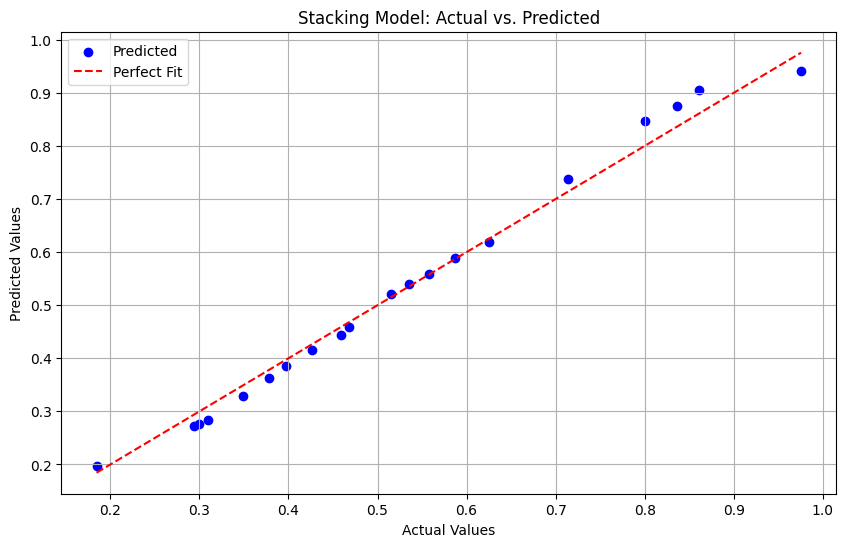

In [ ]:
import matplotlib.pyplot as plt

# Generate actual vs. predicted values plot
def plot_actual_vs_predicted(y_true, y_pred, title="Actual vs. Predicted"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, color='blue', label='Predicted')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--', label='Perfect Fit')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the actual vs. predicted values for the stacking model
plot_actual_vs_predicted(y_test, stacking_preds, title="Stacking Model: Actual vs. Predicted")
